In [7]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from binary_decoders import lecroy
from pathlib import Path
import numpy as np
from importlib import reload
import uproot

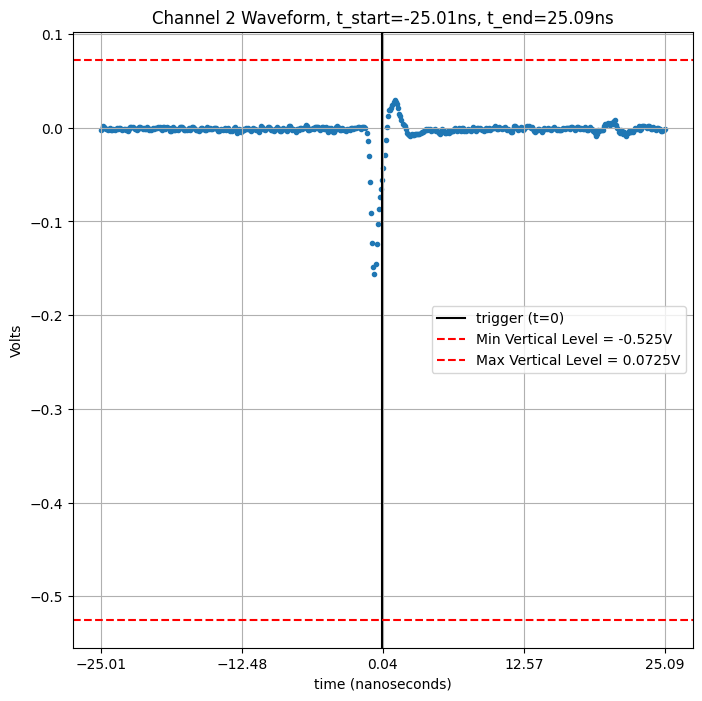

In [59]:
# sudo mount -t cifs //192.168.0.6/Waveforms /home/etl/Test_Stand/daq/LecroyMount -o user=mothra,uid=etl,gid=etl,vers=2.0
reload(lecroy)
run = 2800
trace_file = lambda chnl, run: Path(f'/media/etl/ETL_DESY_Backup/Desy_Mar24/LecroyRaw/C{chnl}--Trace{run}.trc')
pulse = lecroy.LecroyReader(trace_file(chnl=2,run=run))
event = 5
pulse.plot_event(event)

In [67]:
import sys
sys.path.append("/home/etl/Test_Stand/tbanalysis/utils")
import mcp_fit, clock_fit

In [83]:
import awkward as ak
nanoseconds, scaled_volts = mcp_fit.MCPSignalScaler.normalize(
    pulse.x * 1e9, 
    pulse.y, 
    # signal_saturation_level=pulse.minVerticalValue+0.01
)
# i_event = 8
# for i in range(i_event, i_event+1000):
#     n, sv = nanoseconds[i], scaled_volts[i]
#     window = (n < 3) & (n>-2)
#     plt.scatter(n[window], sv[window], marker='.')
#     plt.axvline(0)

peak_times, mcp_amplitude = mcp_fit.MCPSignalScaler.calc_mcp_peaks(nanoseconds, pulse.y)
mcp_timestamps = mcp_fit.linear_interpolation(nanoseconds, scaled_volts, peak_times, threshold=0.4)

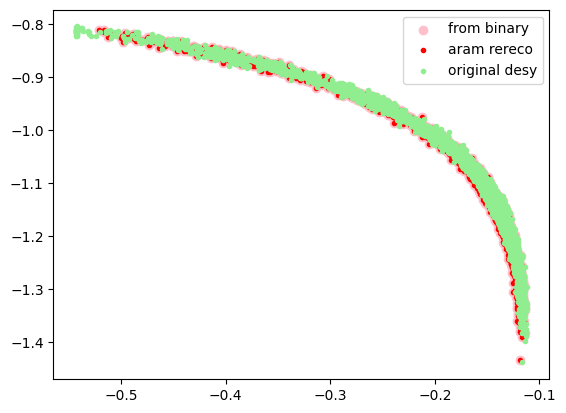

In [89]:
aram_rereco = uproot.open("~/Downloads/run_2800.root")["pulse"].arrays()

od = uproot.open("/media/etl/ETL_DESY_Backup/Desy_Mar24/LecroyMerged/run_2800.root")["pulse"].arrays()

plt.scatter(mcp_amplitude, mcp_timestamps, label="from binary", color='pink')
ns, sv = mcp_fit.MCPSignalScaler.normalize(
    ak.to_numpy(aram_rereco.mcp_seconds)*1e9, 
    ak.to_numpy(aram_rereco.mcp_volts), 
)
pt, ma = mcp_fit.MCPSignalScaler.calc_mcp_peaks(ns, ak.to_numpy(aram_rereco.mcp_volts))
mt = mcp_fit.linear_interpolation(ns, sv, pt, threshold=0.4)
plt.scatter(ma, mt, label="aram rereco", color='red', marker='.')

plt.scatter(od.amp[:,1]/-1000, od.LP2_40[:,1]*1e9, label="original desy", color='lightgreen', marker='.')

plt.legend()